In [46]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import re 
from tqdm import tqdm
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import subprocess


In [8]:
def get_gene_DNA_from_gbf(gene_name,gbf_file):
    """
    Get the DNA sequence of a gene from the GenBank file.
    """
    ret = ""
    with open(gbf_file, "r") as handle:
        for record in SeqIO.parse(handle, "genbank"):
            for feature in record.features:
                if feature.type == "CDS" and "gene" in feature.qualifiers:
                    if gene_name in feature.qualifiers["gene"]:
                        # Extract the DNA sequence
                        dna_sequence = str(feature.location.extract(record.seq))
                        ret = dna_sequence
    if ret:
        return ret
    else:
        #print(f"Gene {gene_name} not found in {gbf_file}.")
        return None

def get_gene_DNA_from_gbf_directory(gene_name, gbf_dir):
    """
    Get the DNA sequences of a gene from the GenBank files in the dir, returning a dictionary.
    """
    gene_sequences = {}
    gbf_files = [f for f in os.listdir(gbf_dir) if f.endswith(".gbf")]
    for gbf_file in tqdm(gbf_files):
        gbf_path = os.path.join(gbf_dir, gbf_file)
        sequence = get_gene_DNA_from_gbf(gene_name, gbf_path)
        if sequence:
            header = f"{gbf_file.split('.')[0]}_{gene_name}"
            gene_sequences[header] = sequence
    return gene_sequences

gbf_directory = "data/gbfs"

In [9]:
#set the working directory to /workdir/hdd29/chloroplast_genome_evaluation
os.chdir("/workdir/hdd29/chloroplast_genome_evaluation")

psbA_sequences = get_gene_DNA_from_gbf_directory("psbA", gbf_directory)


100%|██████████| 53283/53283 [04:47<00:00, 185.18it/s]


In [11]:
#how many are NA 
na_count = sum(1 for seq in psbA_sequences.values() if seq is None)
print(f"Number of NA sequences: {na_count}") 
#it's none ! yay!

#what is the length of the sequences
lengths = [len(seq) for seq in psbA_sequences.values() if seq is not None]
print(f"Number of sequences: {len(lengths)}")

Number of NA sequences: 0
Number of sequences: 52885


Mean length: 1058.80 nucleotides
Median length: 1062.00 nucleotides
Min length: 51 nucleotides
Max length: 1158 nucleotides


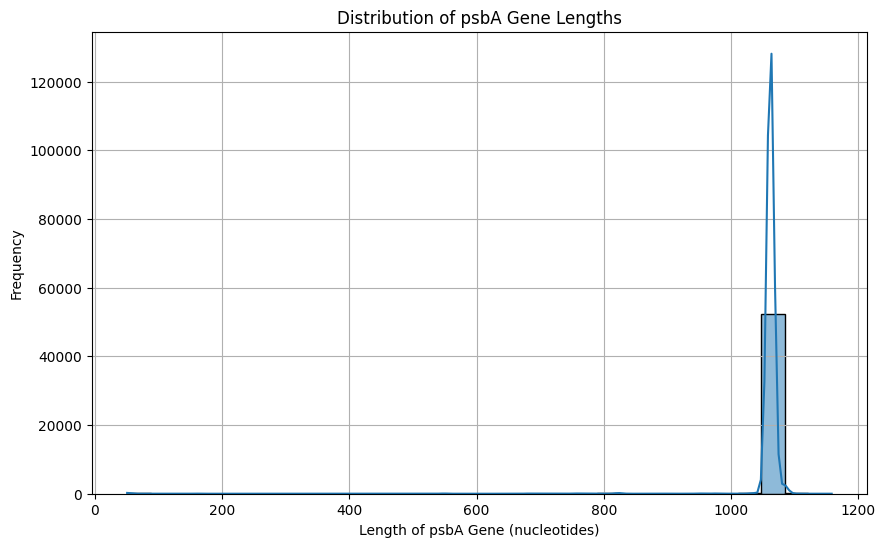

In [13]:
#plot a histogram of the lengths
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True)
plt.title("Distribution of psbA Gene Lengths")
plt.xlabel("Length of psbA Gene (nucleotides)")
plt.ylabel("Frequency")
plt.grid()

#and print summary statistics
print(f"Mean length: {sum(lengths) / len(lengths):.2f} nucleotides")
print(f"Median length: {sorted(lengths)[len(lengths) // 2]:.2f} nucleotides")
print(f"Min length: {min(lengths)} nucleotides")
print(f"Max length: {max(lengths)} nucleotides")


In [ ]:
from sklearn.decomposition import PCA

def compute_dinucleotide_frequencies_per_seq(sequences):
    dinucs = [a+b for a in 'ACTG' for b in 'ACTG']
    freq_matrix = {}
    for header, seq in tqdm(sequences.items()):
        counts = dict.fromkeys(dinucs, 0)
        for i in range(len(seq)-1):
            dp = seq[i:i+2]
            if dp in counts:
                counts[dp] += 1
        total = sum(counts.values())
        freq_matrix[header] = {dp: counts[dp]/total if total>0 else 0 for dp in dinucs}
    return pd.DataFrame.from_dict(freq_matrix, orient='index')

dinucleotide_df = compute_dinucleotide_frequencies_per_seq(psbA_sequences)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dinucleotide_df)


100%|██████████| 52885/52885 [00:11<00:00, 4564.00it/s]


Explained variance ratio: [0.3683339  0.19026179]


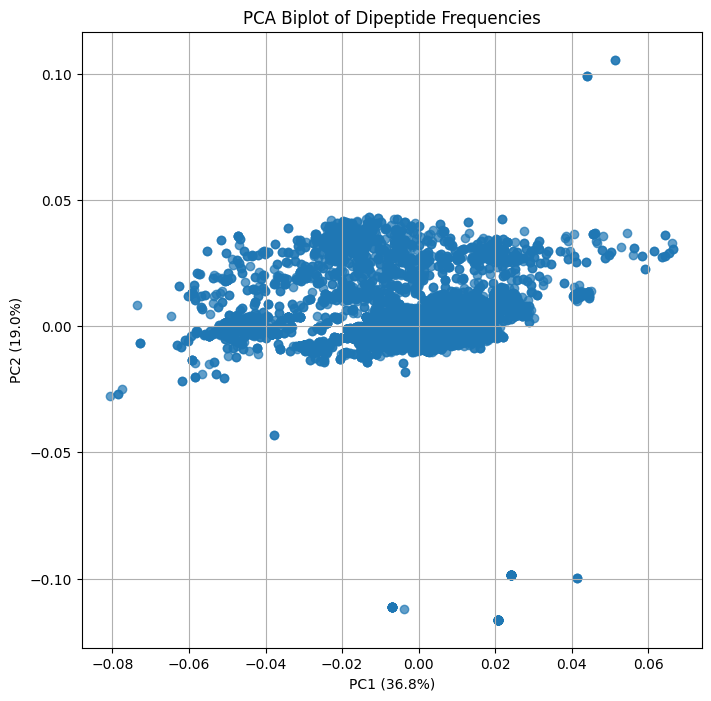

In [31]:
import matplotlib.pyplot as plt
import numpy as np

explained_variance = pca.explained_variance_ratio_
loadings = pca.components_.T

print("Explained variance ratio:", explained_variance)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(pca_result[:,0], pca_result[:,1], alpha=0.7)
"""
for i, dp in enumerate(dipeptide_df.columns):
    ax.arrow(0, 0, loadings[i,0]*3, loadings[i,1]*3, color='r', alpha=0.5)
    ax.text(loadings[i,0]*3.2, loadings[i,1]*3.2, dp, fontsize=8)
"""
ax.set_xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)")
ax.set_title("PCA Biplot of Dipeptide Frequencies")
ax.grid(True)
plt.show()


What I want to find is the DE loop, which is allegedly between helices IV and V (D and E), roughly positions V219 --> S264


RETTENESANEGYR

In [32]:
tax_data = pd.read_csv("data/taxonomy_info.csv")

dinucleotide_df['FileBasename'] = dinucleotide_df.index.str.split('fa').str[0]
#merge on label
merged_df = pd.merge(dinucleotide_df, tax_data, left_on='FileBasename', right_on='FileBasename', how='left')
merged_df

,AA,AC,AT,AG,CA,CC,CT,CG,TA,TC,...,GA,GC,GT,GG,FileBasename,ID,Organism,Taxonomy,Year,SequencingTech
0,0.062382,0.050095,0.081285,0.046314,0.055766,0.043478,0.084121,0.029301,0.075614,0.066163,...,0.046314,0.052930,0.061437,0.052930,MW4209351,MW420935.1,Scutellaria pinnatifida subsp. pichleri,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2024,Illumina
1,0.062382,0.050095,0.081285,0.046314,0.055766,0.043478,0.085066,0.028355,0.075614,0.066163,...,0.046314,0.052930,0.060491,0.052930,MW4209441,MW420944.1,Scutellaria immaculata,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2024,Illumina
2,0.060320,0.043355,0.087653,0.041470,0.048068,0.040528,0.084826,0.029218,0.078228,0.065975,...,0.046183,0.052780,0.060320,0.057493,MW4102371,MW410237.1,Carya kweichowensis,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2022,Illumina
3,0.061263,0.049953,0.080113,0.042413,0.054665,0.047125,0.084826,0.032045,0.075401,0.065033,...,0.042413,0.056550,0.058435,0.057493,MW4462471,MW446247.1,Epimedium pinnatum,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2021,Unknown
4,0.059378,0.045240,0.085768,0.044298,0.051838,0.043355,0.085768,0.026390,0.078228,0.066918,...,0.045240,0.051838,0.062205,0.055608,MW4463461,MW446346.1,Eucalyptus behriana,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2021,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52880,0.056550,0.042413,0.082941,0.045240,0.053723,0.042413,0.092366,0.033930,0.073516,0.077286,...,0.043355,0.060320,0.059378,0.049953,PV7510731,PV751073.1,Taxus sp. SW-2025a,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2025,Unknown
52881,0.056550,0.042413,0.086711,0.044298,0.049953,0.041470,0.084826,0.023563,0.080113,0.066918,...,0.043355,0.049010,0.067861,0.055608,PV8178661,PV817866.1,Allium listera,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2025,Illumina
52882,0.055608,0.045240,0.087653,0.044298,0.052780,0.038643,0.081998,0.022620,0.081056,0.065033,...,0.043355,0.047125,0.066918,0.056550,PV9364461,PV936446.1,Fritillaria taipaiensis,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2025,Illumina
52883,0.059378,0.044298,0.088596,0.043355,0.048068,0.043355,0.083883,0.026390,0.081998,0.061263,...,0.046183,0.052780,0.060320,0.054665,OR6873971,OR687397.1,Prunus pusilliflora,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2024,Illumina


In [35]:
import numpy as np

# List of all dinucleotides
dinucs = [a+b for a in 'ACTG' for b in 'ACTG']

# Compute centroid (mean frequencies)
centroid = merged_df[dinucs].mean()
print("Centroid of Dipeptide Frequencies:")
print(centroid)

# Function to compute Euclidean distance to centroid
def compute_distance_to_centroid(row, centroid):
    return np.linalg.norm(row[dinucs] - centroid)

# Apply function to each row
merged_df['DistanceToCentroid'] = merged_df.apply(lambda row: compute_distance_to_centroid(row, centroid), axis=1)


Centroid of Dipeptide Frequencies:
AA    0.058299
AC    0.046510
AT    0.084196
AG    0.044037
CA    0.051841
CC    0.040838
CT    0.085564
CG    0.027557
TA    0.077867
TC    0.066484
TT    0.113395
TG    0.088048
GA    0.045020
GC    0.051970
GT    0.062642
GG    0.055732
dtype: float64


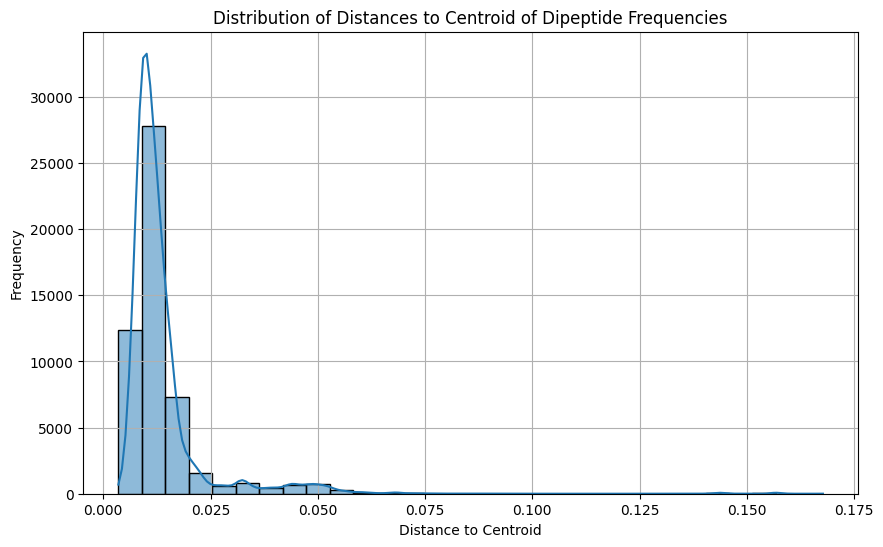

In [36]:
#plot a histogram of the distances to centroid
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['DistanceToCentroid'], bins=30, kde=True)
plt.title("Distribution of Distances to Centroid of Dipeptide Frequencies")
plt.xlabel("Distance to Centroid")
plt.ylabel("Frequency")
plt.grid()

Number of representative sequences: 19726


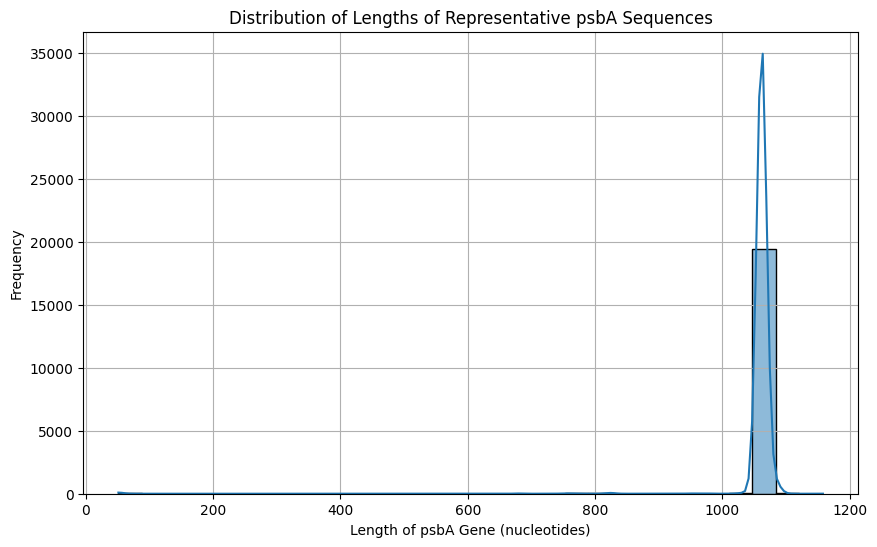

In [39]:
#we need to pick a representative sequence for each species; group the DF by Organism and take the one closest to the centroid
representative_sequences = merged_df.loc[merged_df.groupby('Organism')['DistanceToCentroid'].idxmin()]

#how many representative sequences do we have?)

print(f"Number of representative sequences: {len(representative_sequences)}")

#Plot lengths of representative sequences
lengths_representative = [len(psbA_sequences[seq+"fa_psbA"]) for seq in representative_sequences.FileBasename if seq+"fa_psbA" in psbA_sequences]
plt.figure(figsize=(10, 6))
sns.histplot(lengths_representative, bins=30, kde=True)
plt.title("Distribution of Lengths of Representative psbA Sequences")
plt.xlabel("Length of psbA Gene (nucleotides)")
plt.ylabel("Frequency")
plt.grid()

In [41]:
min(lengths_representative), max(lengths_representative), np.mean(lengths_representative), np.median(lengths_representative)

sum(lengths_representative < 800)

TypeError: '<' not supported between instances of 'list' and 'int'

In [44]:
# Assume psbA_sequences is a dict-like: {seq_id: SeqRecord}
# Add sequences to merged_df: match 'FileBasename' + "fa_psbA" keys in psbA_sequences
def get_sequence(row):
    key = row['FileBasename'] + "fa_psbA"
    return str(psbA_sequences[key]) if key in psbA_sequences else None

merged_df['Sequence'] = merged_df.apply(get_sequence, axis=1)

# Filter by length cutoff
length_cutoff = 500  # for example
merged_df = merged_df[merged_df['Sequence'].apply(lambda x: x is not None and len(x) >= length_cutoff)]

# Compute dinucleotide centroid as you had before
dinucs = [a+b for a in 'ACTG' for b in 'ACTG']
centroid = merged_df[dinucs].mean()

def compute_distance_to_centroid(row, centroid):
    return ((row[dinucs] - centroid)**2).sum()**0.5

merged_df['DistanceToCentroid'] = merged_df.apply(lambda row: compute_distance_to_centroid(row, centroid), axis=1)

# Pick representative sequences: closest to centroid per Organism
representative_sequences = merged_df.loc[merged_df.groupby('Organism')['DistanceToCentroid'].idxmin()]

print(f"Number of representative sequences: {len(representative_sequences)}")

# Save representatives to a Multi-FASTA file
records = []
for _, row in tqdm(representative_sequences.iterrows()):
    records.append(SeqRecord(seq=row['Sequence'], id=row['FileBasename'], description=row['Organism']))

SeqIO.write(records, "data/psbA.fa", "fasta")


/tmp/ipykernel_326824/2116040218.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['DistanceToCentroid'] = merged_df.apply(lambda row: compute_distance_to_centroid(row, centroid), axis=1)


Number of representative sequences: 19671


0it [00:00, ?it/s]/workdir/hdd29/chloroplast_genome_evaluation/.pixi/envs/default/lib/python3.13/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(
19671it [00:01, 17814.79it/s]


19671

In [47]:
def align_genes_with_threads(input_fasta, output_fasta, threads=4):
    """
    Align sequences in a FASTA file using MAFFT with multithreading.
    
    :param input_fasta: Path to input FASTA file
    :param output_fasta: Path to output aligned FASTA file
    :param threads: Number of threads to use (default: 4)
    """
    for VROOM in range(threads):
      print("VROOM")
    with open(output_fasta, 'w') as out_f:
        subprocess.run(
            ["/programs/mafft/bin/mafft", "--auto","--treeout","--distout", "--adjustdirection",
            "--thread", str(threads),
            "--threadtb", str(threads),
            "--threadit", str(threads),
            input_fasta], 
            stdout=out_f,
            check=True
        )

align_genes_with_threads("data/psbA.fa", "data/psbA_aligned.fa", threads=7)

VROOM
VROOM
VROOM
VROOM
VROOM
VROOM
VROOM


nthread = 7
nadd = 0
inputfile = infile
thresholdtorev = 0.000000
reflim = 5000
mode = a
generating a scoring matrix for nucleotide (dist=200) ... done

Step 1/2
19601   

Step 2/2
 19601 / 19671 (7 threads)   
makedirectionlist (nuc) Version 7.522
alg=m, model=DNA200 (2), 1.53 (4.59), 0.37 (1.11), noshift, amax=0.0
7 thread(s)

directionfile = _direction
inputfile = infile
subalignment = 0
subalignmentoffset = 0
19671 x 1158 - 534 d
nthread = 7
nthreadpair = 7
nthreadtb = 7
distout=h
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 154 ambiguous characters.
 19601 / 19671 (thread    3)
done.

Constructing a UPGMA tree (treeout, efffree=0) ... 
 19660 / 19671
done.

Progressive alignment 1/2... 
STEP  19301 / 19670 (thread    5) h
Reallocating..done. *alloclen = 3437
STEP  19601 / 19670 (thread    5)
done.

Making a distance matrix from msa.. 
 19600 / 19671 (thr

In [ ]:
#how many sequences do not begin with ATG 